In [12]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn import preprocessing
#import scipy.io as sio

from models import AE
from models import DNN
import numpy as np
import pandas as pd
import umap


In [2]:
from scipy.stats import pearsonr

# Parameters

In [3]:
# Define parameters
epochs = 500 #200,500,1000
dim_au_in = 20049
dim_au_out = 512 #8, 16, 32, 64, 128, 256,512
dim_dnn_in = dim_au_out
dim_dnn_out=1

# Import data

In [4]:
data_r=pd.read_csv('data/CCLEexpression.csv',index_col=0)
label_r=pd.read_csv('data/CCLElabel.csv',index_col=0)

In [5]:
label_r=label_r.fillna(1)

# Your is gene-cell, mine is cell-gene

In [6]:
len(set(data_r.index))

1028

In [7]:
data = data_r
label = label_r.iloc[:,10]
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
data = scaler.fit_transform(data)

In [8]:
print(np.std(data))
print(np.mean(data))

1.0000000000000007
9.609391303179367e-18


In [9]:
data.shape

(1028, 20049)

In [10]:
label_r.shape

(1028, 24)

In [15]:
reducer = umap.UMAP(n_components=dim_au_out)
feature = reducer.fit_transform(data)
feature.shape


(1028, 512)

# Split test train

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(feature, label, test_size=0.2, random_state=42)

In [22]:
print(data.shape)
print(label.shape)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1028, 20049)
(1028,)
(822, 512) (822,)
(206, 512) (206,)


In [23]:
print(X_train.max())
print(X_train.min())

12.314547
-2.0163622


# The model

In [24]:
print(feature.shape)

(1028, 512)


In [25]:
feature

array([[-0.6284153 ,  2.64048   ,  7.822365  , ...,  4.9116764 ,
         3.961404  ,  6.065216  ],
       [-0.55354124,  2.6278815 ,  8.441895  , ...,  4.940139  ,
         4.0273013 ,  6.0809135 ],
       [-0.02087876,  2.273943  ,  9.549631  , ...,  4.93702   ,
         4.0757904 ,  6.0784817 ],
       ...,
       [-0.53586686,  1.8748491 , 10.350428  , ...,  5.070954  ,
         4.009118  ,  6.3117995 ],
       [-0.53136283,  1.8798865 , 10.370706  , ...,  5.0876503 ,
         4.023037  ,  6.323208  ],
       [-0.57351154,  1.8416744 , 10.356359  , ...,  5.0666966 ,
         4.0065064 ,  6.315062  ]], dtype=float32)

In [27]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, Y_train.values)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
lasso = clf.predict(X_test)

In [30]:
r2_score(lasso,Y_test)

-63822120228462.2

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feature)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1028 samples in 0.016s...
[t-SNE] Computed neighbors for 1028 samples in 0.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1028
[t-SNE] Computed conditional probabilities for sample 1028 / 1028
[t-SNE] Mean sigma: 0.438583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.370693
[t-SNE] KL divergence after 300 iterations: 0.331599


In [32]:
tsne_results

array([[ 6.9698024, 10.001676 ],
       [ 2.655806 ,  4.567106 ],
       [-5.7184095, -7.0123587],
       ...,
       [-9.733771 , 16.320114 ],
       [-9.739176 , 16.318007 ],
       [-9.73098  , 16.32812  ]], dtype=float32)

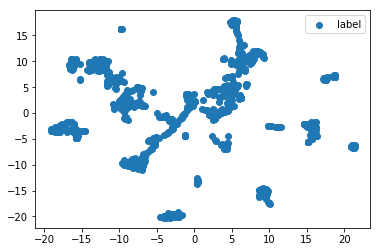

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label="label")
plt.legend()
plt.savefig("saved/figrues/tsne_umap_ccle.png")

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
torch.cuda.set_device(device)

cuda:0


In [38]:
EPOCH = 500

In [41]:
# Load data
# data type conversion
B_feature = torch.FloatTensor(X_train).to(device)
y = torch.FloatTensor(Y_train.values).to(device)
# construct TensorDataset
b_data = TensorDataset(B_feature, y)
trainDataLoader2 = DataLoader(dataset=b_data, batch_size=200, shuffle=False)

In [42]:
b_data.tensors

(tensor([[ 0.2789,  2.7570,  8.2525,  ...,  4.8696,  4.1040,  5.9283],
         [ 0.0286,  2.4742,  9.1081,  ...,  4.9368,  4.0456,  6.0818],
         [-0.1135,  2.3471,  9.6292,  ...,  4.9682,  4.0075,  6.1434],
         ...,
         [-0.0723,  2.4499,  9.5382,  ...,  4.9474,  3.9622,  6.1377],
         [ 0.0450,  3.0332,  6.5981,  ...,  4.9518,  4.0159,  6.0142],
         [-0.2217,  2.4223,  9.5259,  ...,  4.9425,  3.9489,  6.1357]],
        device='cuda:0'),
 tensor([1.0000e+00, 0.0000e+00, 3.4175e-02, 1.1038e-01, 1.6875e-02, 1.1775e-02,
         8.0300e-02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.6525e-02, 1.0000e+00,
         1.0000e+00, 1.4516e-01, 4.1538e-02, 0.0000e+00, 1.2575e-02, 8.5887e-02,
         4.3750e-02, 1.0000e+00, 2.0725e-01, 6.4675e-02, 1.0000e+00, 1.0239e-01,
         1.0000e+00, 9.5000e-02, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
         7.0250e-03, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.8875e-03, 1.0000e+00,
         1.0000e+00, 3.1250e-02, 1.0000e+00, 3.

In [ ]:
b_data

In [ ]:
dim_dnn_in

In [43]:
# Initialization DNN model

predictor = DNN(dim_dnn_in, dim_dnn_out).to(device)
optimizer = optim.Adam(predictor.parameters(), lr=1e-3,betas=(0.9,0.99))
#loss1-softmax
loss_func = nn.MSELoss().to(device)
#loss2-sigmoid
#loss_func = nn.BCELoss()
#loss3-sigmoid
#loss_func = nn.CrossEntropyLoss()

#criterion = torch.nn.MSELoss(size_average=True)
#criterion = torch.nn.BCELoss(size_average=True) # Defined loss function
#optimizer = optim.Adm(model.parameters(), lr=0.01) # Defined optimizer
loss_train = np.zeros((epochs, 1))

In [44]:
# train model
for epoch in range(EPOCH):
    print('Epoch: ',epoch)
    for step,(batch_x,batch_y) in enumerate(trainDataLoader2):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        # predict label
        output = predictor(b_x)
        # b_y=F.sigmoid(b_y) 
        
        #print
        #print(output)
        #print(b_y)
        # compute loss
        loss = loss_func(output,b_y)
        #loss = criterion(output, b_y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item())) 


Epoch:  0


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0001, Training loss=0.23459573
Epoch:  1


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0002, Training loss=0.25371563
Epoch:  2


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0003, Training loss=0.22219390
Epoch:  3


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0004, Training loss=0.22814348
Epoch:  4


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0005, Training loss=0.22488497
Epoch:  5


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0006, Training loss=0.22311309
Epoch:  6


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0007, Training loss=0.22735274
Epoch:  7


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0008, Training loss=0.22354591
Epoch:  8


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0009, Training loss=0.22449812
Epoch:  9


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0010, Training loss=0.22539884
Epoch:  10


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0011, Training loss=0.22387397
Epoch:  11


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0012, Training loss=0.22472227
Epoch:  12


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0013, Training loss=0.22473790
Epoch:  13


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0014, Training loss=0.22415930
Epoch:  14


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0015, Training loss=0.22461323
Epoch:  15


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0016, Training loss=0.22451168
Epoch:  16


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0017, Training loss=0.22427884
Epoch:  17


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0018, Training loss=0.22447540
Epoch:  18


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0019, Training loss=0.22441037
Epoch:  19


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0020, Training loss=0.22429486
Epoch:  20


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0021, Training loss=0.22436394
Epoch:  21


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0022, Training loss=0.22433560
Epoch:  22


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0023, Training loss=0.22426550
Epoch:  23


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0024, Training loss=0.22427318
Epoch:  24


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0025, Training loss=0.22426425
Epoch:  25


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0026, Training loss=0.22421947
Epoch:  26


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0027, Training loss=0.22420135
Epoch:  27


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0028, Training loss=0.22419104
Epoch:  28


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0029, Training loss=0.22415698
Epoch:  29


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0030, Training loss=0.22414009
Epoch:  30


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0031, Training loss=0.22413780
Epoch:  31


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0032, Training loss=0.22409971
Epoch:  32


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0033, Training loss=0.22413868
Epoch:  33


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0034, Training loss=0.22414170
Epoch:  34


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0035, Training loss=0.22403540
Epoch:  35


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0036, Training loss=0.22405380
Epoch:  36


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0037, Training loss=0.22411163
Epoch:  37


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0038, Training loss=0.22407538
Epoch:  38


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0039, Training loss=0.22474258
Epoch:  39


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0040, Training loss=0.22404969
Epoch:  40


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0041, Training loss=0.22395453
Epoch:  41


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0042, Training loss=0.22541119
Epoch:  42


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0043, Training loss=0.22435237
Epoch:  43


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0044, Training loss=0.22408587
Epoch:  44


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0045, Training loss=0.22436129
Epoch:  45


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0046, Training loss=0.22427988
Epoch:  46


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0047, Training loss=0.22408497
Epoch:  47


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0048, Training loss=0.22402959
Epoch:  48


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0049, Training loss=0.22408974
Epoch:  49


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0050, Training loss=0.22405405
Epoch:  50


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0051, Training loss=0.22397682
Epoch:  51


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0052, Training loss=0.22394052
Epoch:  52


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0053, Training loss=0.22393340
Epoch:  53


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0054, Training loss=0.22388762
Epoch:  54


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0055, Training loss=0.22453430
Epoch:  55


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0056, Training loss=0.22400779
Epoch:  56


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0057, Training loss=0.22468418
Epoch:  57


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0058, Training loss=0.22421829
Epoch:  58


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0059, Training loss=0.22444242
Epoch:  59


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0060, Training loss=0.22396623
Epoch:  60


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0061, Training loss=0.22395493
Epoch:  61


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0062, Training loss=0.22408375
Epoch:  62


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0063, Training loss=0.22415122
Epoch:  63


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0064, Training loss=0.22410928
Epoch:  64


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0065, Training loss=0.22383347
Epoch:  65


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0066, Training loss=0.22447012
Epoch:  66


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0067, Training loss=0.22380762
Epoch:  67


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0068, Training loss=0.22432443
Epoch:  68


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0069, Training loss=0.22425772
Epoch:  69


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0070, Training loss=0.22389199
Epoch:  70


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0071, Training loss=0.22430725
Epoch:  71


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0072, Training loss=0.22393924
Epoch:  72


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0073, Training loss=0.22366211
Epoch:  73


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0074, Training loss=0.22441696
Epoch:  74


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0075, Training loss=0.22434169
Epoch:  75


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0076, Training loss=0.22391830
Epoch:  76


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0077, Training loss=0.22377142
Epoch:  77


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0078, Training loss=0.22385834
Epoch:  78


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0079, Training loss=0.22396331
Epoch:  79


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0080, Training loss=0.22399239
Epoch:  80


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0081, Training loss=0.22387722
Epoch:  81


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0082, Training loss=0.22383173
Epoch:  82


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0083, Training loss=0.22383913
Epoch:  83


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0084, Training loss=0.22387084
Epoch:  84


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0085, Training loss=0.22389121
Epoch:  85


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0086, Training loss=0.22388744
Epoch:  86


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0087, Training loss=0.22387102
Epoch:  87


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0088, Training loss=0.22386026
Epoch:  88


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0089, Training loss=0.22385922
Epoch:  89


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0090, Training loss=0.22386640
Epoch:  90


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0091, Training loss=0.22386630
Epoch:  91


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0092, Training loss=0.22386524
Epoch:  92


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0093, Training loss=0.22389293
Epoch:  93


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0094, Training loss=0.22380595
Epoch:  94


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0095, Training loss=0.22380789
Epoch:  95


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0096, Training loss=0.22384650
Epoch:  96


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0097, Training loss=0.22388901
Epoch:  97


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0098, Training loss=0.22391903
Epoch:  98


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0099, Training loss=0.22390290
Epoch:  99


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0100, Training loss=0.22385825
Epoch:  100


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0101, Training loss=0.22383398
Epoch:  101


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0102, Training loss=0.22383717
Epoch:  102


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0103, Training loss=0.22386184
Epoch:  103


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0104, Training loss=0.22386175
Epoch:  104


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0105, Training loss=0.22385976
Epoch:  105


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0106, Training loss=0.22385122
Epoch:  106


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0107, Training loss=0.22384956
Epoch:  107


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0108, Training loss=0.22384240
Epoch:  108


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0109, Training loss=0.22384138
Epoch:  109


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0110, Training loss=0.22385108
Epoch:  110


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0111, Training loss=0.22385348
Epoch:  111


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0112, Training loss=0.22384767
Epoch:  112


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0113, Training loss=0.22383521
Epoch:  113


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0114, Training loss=0.22382234
Epoch:  114


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0115, Training loss=0.22382560
Epoch:  115


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0116, Training loss=0.22381191
Epoch:  116


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0117, Training loss=0.22381881
Epoch:  117


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0118, Training loss=0.22382410
Epoch:  118


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0119, Training loss=0.22382610
Epoch:  119


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0120, Training loss=0.22382565
Epoch:  120


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0121, Training loss=0.22381668
Epoch:  121


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0122, Training loss=0.22380580
Epoch:  122


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0123, Training loss=0.22380263
Epoch:  123


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0124, Training loss=0.22380903
Epoch:  124


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0125, Training loss=0.22381128
Epoch:  125


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0126, Training loss=0.22380185
Epoch:  126


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0127, Training loss=0.22402059
Epoch:  127


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0128, Training loss=0.22398536
Epoch:  128


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0129, Training loss=0.22379276
Epoch:  129


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0130, Training loss=0.22375280
Epoch:  130


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0131, Training loss=0.22377777
Epoch:  131


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0132, Training loss=0.22392300
Epoch:  132


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0133, Training loss=0.22394872
Epoch:  133


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0134, Training loss=0.22387841
Epoch:  134


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0135, Training loss=0.22422558
Epoch:  135


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0136, Training loss=0.22414079
Epoch:  136


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0137, Training loss=0.22381893
Epoch:  137


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0138, Training loss=0.22367921
Epoch:  138


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0139, Training loss=0.22369327
Epoch:  139


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0140, Training loss=0.22374135
Epoch:  140


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0141, Training loss=0.22381279
Epoch:  141


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0142, Training loss=0.22386147
Epoch:  142


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0143, Training loss=0.22386956
Epoch:  143


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0144, Training loss=0.22384942
Epoch:  144


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0145, Training loss=0.22382259
Epoch:  145


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0146, Training loss=0.22380225
Epoch:  146


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0147, Training loss=0.22379330
Epoch:  147


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0148, Training loss=0.22379510
Epoch:  148


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0149, Training loss=0.22379895
Epoch:  149


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0150, Training loss=0.22380377
Epoch:  150


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0151, Training loss=0.22381058
Epoch:  151


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0152, Training loss=0.22381143
Epoch:  152


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0153, Training loss=0.22381184
Epoch:  153


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0154, Training loss=0.22381090
Epoch:  154


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0155, Training loss=0.22380827
Epoch:  155


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0156, Training loss=0.22380425
Epoch:  156


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0157, Training loss=0.22380403
Epoch:  157


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0158, Training loss=0.22380213
Epoch:  158


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0159, Training loss=0.22380002
Epoch:  159


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0160, Training loss=0.22380182
Epoch:  160


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0161, Training loss=0.22380210
Epoch:  161


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0162, Training loss=0.22380039
Epoch:  162


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0163, Training loss=0.22379944
Epoch:  163


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0164, Training loss=0.22379857
Epoch:  164


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0165, Training loss=0.22379637
Epoch:  165


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0166, Training loss=0.22379649
Epoch:  166


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0167, Training loss=0.22379583
Epoch:  167


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0168, Training loss=0.22379315
Epoch:  168


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0169, Training loss=0.22379397
Epoch:  169


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0170, Training loss=0.22379203
Epoch:  170


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0171, Training loss=0.22378795
Epoch:  171


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0172, Training loss=0.22378851
Epoch:  172


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0173, Training loss=0.22379218
Epoch:  173


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0174, Training loss=0.22379094
Epoch:  174


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0175, Training loss=0.22379109
Epoch:  175


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0176, Training loss=0.22378892
Epoch:  176


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0177, Training loss=0.22378598
Epoch:  177


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0178, Training loss=0.22378549
Epoch:  178


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0179, Training loss=0.22378337
Epoch:  179


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0180, Training loss=0.22378239
Epoch:  180


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0181, Training loss=0.22378176
Epoch:  181


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0182, Training loss=0.22378026
Epoch:  182


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0183, Training loss=0.22377954
Epoch:  183


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0184, Training loss=0.22377893
Epoch:  184


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0185, Training loss=0.22377796
Epoch:  185


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0186, Training loss=0.22377896
Epoch:  186


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0187, Training loss=0.22377701
Epoch:  187


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0188, Training loss=0.22377598
Epoch:  188


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0189, Training loss=0.22377549
Epoch:  189


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0190, Training loss=0.22377414
Epoch:  190


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0191, Training loss=0.22377501
Epoch:  191


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0192, Training loss=0.22377256
Epoch:  192


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0193, Training loss=0.22377259
Epoch:  193


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0194, Training loss=0.22377089
Epoch:  194


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0195, Training loss=0.22377063
Epoch:  195


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0196, Training loss=0.22376789
Epoch:  196


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0197, Training loss=0.22376688
Epoch:  197


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0198, Training loss=0.22377297
Epoch:  198


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0199, Training loss=0.22377326
Epoch:  199


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0200, Training loss=0.22377177
Epoch:  200


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0201, Training loss=0.22377375
Epoch:  201


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0202, Training loss=0.22377077
Epoch:  202


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0203, Training loss=0.22377031
Epoch:  203


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0204, Training loss=0.22376819
Epoch:  204


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0205, Training loss=0.22376919
Epoch:  205


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0206, Training loss=0.22376776
Epoch:  206


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0207, Training loss=0.22376862
Epoch:  207


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0208, Training loss=0.22376683
Epoch:  208


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0209, Training loss=0.22376764
Epoch:  209


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0210, Training loss=0.22376598
Epoch:  210


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0211, Training loss=0.22376780
Epoch:  211


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0212, Training loss=0.22376511
Epoch:  212


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0213, Training loss=0.22376731
Epoch:  213


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0214, Training loss=0.22376513
Epoch:  214


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0215, Training loss=0.22376604
Epoch:  215


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0216, Training loss=0.22376463
Epoch:  216


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0217, Training loss=0.22376578
Epoch:  217


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0218, Training loss=0.22376391
Epoch:  218


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0219, Training loss=0.22376642
Epoch:  219


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0220, Training loss=0.22376314
Epoch:  220


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0221, Training loss=0.22376651
Epoch:  221


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0222, Training loss=0.22376396
Epoch:  222


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0223, Training loss=0.22376692
Epoch:  223


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0224, Training loss=0.22376342
Epoch:  224


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0225, Training loss=0.22376736
Epoch:  225


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0226, Training loss=0.22376379
Epoch:  226


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0227, Training loss=0.22376820
Epoch:  227


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0228, Training loss=0.22376442
Epoch:  228


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0229, Training loss=0.22376847
Epoch:  229


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0230, Training loss=0.22376868
Epoch:  230


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0231, Training loss=0.22377038
Epoch:  231


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0232, Training loss=0.22377037
Epoch:  232


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0233, Training loss=0.22377269
Epoch:  233


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0234, Training loss=0.22377029
Epoch:  234


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0235, Training loss=0.22377335
Epoch:  235


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0236, Training loss=0.22377323
Epoch:  236


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0237, Training loss=0.22377422
Epoch:  237


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0238, Training loss=0.22377320
Epoch:  238


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0239, Training loss=0.22377509
Epoch:  239


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0240, Training loss=0.22377257
Epoch:  240


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0241, Training loss=0.22377436
Epoch:  241


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0242, Training loss=0.22377440
Epoch:  242


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0243, Training loss=0.22377408
Epoch:  243


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0244, Training loss=0.22377545
Epoch:  244


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0245, Training loss=0.22377470
Epoch:  245


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0246, Training loss=0.22377586
Epoch:  246


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0247, Training loss=0.22377630
Epoch:  247


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0248, Training loss=0.22378224
Epoch:  248


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0249, Training loss=0.22378217
Epoch:  249


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0250, Training loss=0.22378638
Epoch:  250


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0251, Training loss=0.22376156
Epoch:  251


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0252, Training loss=0.22355856
Epoch:  252


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0253, Training loss=0.22360873
Epoch:  253


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0254, Training loss=0.22366109
Epoch:  254


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0255, Training loss=0.22370239
Epoch:  255


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0256, Training loss=0.22373518
Epoch:  256


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0257, Training loss=0.22376105
Epoch:  257


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0258, Training loss=0.22378078
Epoch:  258


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0259, Training loss=0.22379510
Epoch:  259


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0260, Training loss=0.22380497
Epoch:  260


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0261, Training loss=0.22381137
Epoch:  261


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0262, Training loss=0.22381516
Epoch:  262


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0263, Training loss=0.22381693
Epoch:  263


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0264, Training loss=0.22381686
Epoch:  264


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0265, Training loss=0.22382566
Epoch:  265


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0266, Training loss=0.22381201
Epoch:  266


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0267, Training loss=0.22381258
Epoch:  267


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0268, Training loss=0.22381866
Epoch:  268


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0269, Training loss=0.22382833
Epoch:  269


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0270, Training loss=0.22383933
Epoch:  270


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0271, Training loss=0.22385035
Epoch:  271


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0272, Training loss=0.22386061
Epoch:  272


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0273, Training loss=0.22386971
Epoch:  273


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0274, Training loss=0.22387750
Epoch:  274


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0275, Training loss=0.22388405
Epoch:  275


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0276, Training loss=0.22388941
Epoch:  276


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0277, Training loss=0.22389372
Epoch:  277


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0278, Training loss=0.22389710
Epoch:  278


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0279, Training loss=0.22389977
Epoch:  279


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0280, Training loss=0.22390181
Epoch:  280


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0281, Training loss=0.22390336
Epoch:  281


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0282, Training loss=0.22390454
Epoch:  282


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0283, Training loss=0.22390540
Epoch:  283


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0284, Training loss=0.22390601
Epoch:  284


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0285, Training loss=0.22390647
Epoch:  285


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0286, Training loss=0.22390679
Epoch:  286


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0287, Training loss=0.22390701
Epoch:  287


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0288, Training loss=0.22390714
Epoch:  288


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0289, Training loss=0.22390723
Epoch:  289


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0290, Training loss=0.22390728
Epoch:  290


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0291, Training loss=0.22390731
Epoch:  291


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0292, Training loss=0.22390731
Epoch:  292


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0293, Training loss=0.22390731
Epoch:  293


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0294, Training loss=0.22390729
Epoch:  294


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0295, Training loss=0.22390729
Epoch:  295


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0296, Training loss=0.22390726
Epoch:  296


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0297, Training loss=0.22390725
Epoch:  297


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0298, Training loss=0.22390720
Epoch:  298


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0299, Training loss=0.22390720
Epoch:  299


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0300, Training loss=0.22390719
Epoch:  300


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0301, Training loss=0.22390717
Epoch:  301


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0302, Training loss=0.22390714
Epoch:  302


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0303, Training loss=0.22390714
Epoch:  303


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0304, Training loss=0.22390711
Epoch:  304


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0305, Training loss=0.22390710
Epoch:  305


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0306, Training loss=0.22390710
Epoch:  306


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0307, Training loss=0.22390710
Epoch:  307


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0308, Training loss=0.22390708
Epoch:  308


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0309, Training loss=0.22390707
Epoch:  309


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0310, Training loss=0.22390705
Epoch:  310


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0311, Training loss=0.22390705
Epoch:  311


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0312, Training loss=0.22390704
Epoch:  312


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0313, Training loss=0.22390704
Epoch:  313


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0314, Training loss=0.22390702
Epoch:  314


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0315, Training loss=0.22390702
Epoch:  315


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0316, Training loss=0.22390701
Epoch:  316


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0317, Training loss=0.22390701
Epoch:  317


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0318, Training loss=0.22390699
Epoch:  318


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0319, Training loss=0.22390699
Epoch:  319


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0320, Training loss=0.22390699
Epoch:  320


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0321, Training loss=0.22390696
Epoch:  321


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0322, Training loss=0.22390696
Epoch:  322


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0323, Training loss=0.22390696
Epoch:  323


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0324, Training loss=0.22390693
Epoch:  324


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0325, Training loss=0.22390693
Epoch:  325


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0326, Training loss=0.22390693
Epoch:  326


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0327, Training loss=0.22390693
Epoch:  327


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0328, Training loss=0.22390692
Epoch:  328


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0329, Training loss=0.22390692
Epoch:  329


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0330, Training loss=0.22390690
Epoch:  330


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0331, Training loss=0.22390690
Epoch:  331


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0332, Training loss=0.22390690
Epoch:  332


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0333, Training loss=0.22390690
Epoch:  333


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0334, Training loss=0.22390690
Epoch:  334


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0335, Training loss=0.22390690
Epoch:  335


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0336, Training loss=0.22390690
Epoch:  336


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0337, Training loss=0.22390689
Epoch:  337


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0338, Training loss=0.22390687
Epoch:  338


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0339, Training loss=0.22390687
Epoch:  339


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0340, Training loss=0.22390687
Epoch:  340


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0341, Training loss=0.22390687
Epoch:  341


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0342, Training loss=0.22390686
Epoch:  342


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0343, Training loss=0.22390686
Epoch:  343


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0344, Training loss=0.22390686
Epoch:  344


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0345, Training loss=0.22390686
Epoch:  345


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0346, Training loss=0.22390686
Epoch:  346


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0347, Training loss=0.22390684
Epoch:  347


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0348, Training loss=0.22390684
Epoch:  348


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0349, Training loss=0.22390684
Epoch:  349


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0350, Training loss=0.22390683
Epoch:  350


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0351, Training loss=0.22390683
Epoch:  351


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0352, Training loss=0.22390684
Epoch:  352


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0353, Training loss=0.22390683
Epoch:  353


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0354, Training loss=0.22390683
Epoch:  354


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0355, Training loss=0.22390683
Epoch:  355


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0356, Training loss=0.22390682
Epoch:  356


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0357, Training loss=0.22390682
Epoch:  357


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0358, Training loss=0.22390682
Epoch:  358


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0359, Training loss=0.22390682
Epoch:  359


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0360, Training loss=0.22390682
Epoch:  360


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0361, Training loss=0.22390682
Epoch:  361


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0362, Training loss=0.22390682
Epoch:  362


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0363, Training loss=0.22390682
Epoch:  363


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0364, Training loss=0.22390680
Epoch:  364


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0365, Training loss=0.22390680
Epoch:  365


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0366, Training loss=0.22390680
Epoch:  366


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0367, Training loss=0.22390680
Epoch:  367


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0368, Training loss=0.22390680
Epoch:  368


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0369, Training loss=0.22390680
Epoch:  369


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0370, Training loss=0.22390680
Epoch:  370


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0371, Training loss=0.22390679
Epoch:  371


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0372, Training loss=0.22390679
Epoch:  372


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0373, Training loss=0.22390679
Epoch:  373


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0374, Training loss=0.22390679
Epoch:  374


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0375, Training loss=0.22390677
Epoch:  375


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0376, Training loss=0.22390677
Epoch:  376


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0377, Training loss=0.22390677
Epoch:  377


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0378, Training loss=0.22390677
Epoch:  378


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0379, Training loss=0.22390677
Epoch:  379


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0380, Training loss=0.22390677
Epoch:  380


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0381, Training loss=0.22390677
Epoch:  381


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0382, Training loss=0.22390677
Epoch:  382


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0383, Training loss=0.22390677
Epoch:  383


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0384, Training loss=0.22390676
Epoch:  384


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0385, Training loss=0.22390676
Epoch:  385


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0386, Training loss=0.22390676
Epoch:  386


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0387, Training loss=0.22390676
Epoch:  387


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0388, Training loss=0.22390676
Epoch:  388


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0389, Training loss=0.22390676
Epoch:  389


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0390, Training loss=0.22390674
Epoch:  390


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0391, Training loss=0.22390674
Epoch:  391


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0392, Training loss=0.22390674
Epoch:  392


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0393, Training loss=0.22390674
Epoch:  393


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0394, Training loss=0.22390674
Epoch:  394


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0395, Training loss=0.22390673
Epoch:  395


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0396, Training loss=0.22390673
Epoch:  396


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0397, Training loss=0.22390673
Epoch:  397


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0398, Training loss=0.22390673
Epoch:  398


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0399, Training loss=0.22390673
Epoch:  399


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0400, Training loss=0.22390673
Epoch:  400


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0401, Training loss=0.22390673
Epoch:  401


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0402, Training loss=0.22390673
Epoch:  402


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0403, Training loss=0.22390673
Epoch:  403


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0404, Training loss=0.22390671
Epoch:  404


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0405, Training loss=0.22390671
Epoch:  405


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0406, Training loss=0.22390671
Epoch:  406


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0407, Training loss=0.22390671
Epoch:  407


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0408, Training loss=0.22390670
Epoch:  408


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0409, Training loss=0.22390670
Epoch:  409


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0410, Training loss=0.22390670
Epoch:  410


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0411, Training loss=0.22390670
Epoch:  411


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0412, Training loss=0.22390670
Epoch:  412


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0413, Training loss=0.22390670
Epoch:  413


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0414, Training loss=0.22390670
Epoch:  414


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0415, Training loss=0.22390667
Epoch:  415


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0416, Training loss=0.22390667
Epoch:  416


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0417, Training loss=0.22390665
Epoch:  417


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0418, Training loss=0.22390665
Epoch:  418


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0419, Training loss=0.22390665
Epoch:  419


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0420, Training loss=0.22390665
Epoch:  420


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0421, Training loss=0.22390665
Epoch:  421


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0422, Training loss=0.22390664
Epoch:  422


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0423, Training loss=0.22390664
Epoch:  423


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0424, Training loss=0.22390664
Epoch:  424


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0425, Training loss=0.22390664
Epoch:  425


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0426, Training loss=0.22390664
Epoch:  426


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0427, Training loss=0.22390664
Epoch:  427


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0428, Training loss=0.22390662
Epoch:  428


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0429, Training loss=0.22390662
Epoch:  429


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0430, Training loss=0.22390662
Epoch:  430


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0431, Training loss=0.22390662
Epoch:  431


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0432, Training loss=0.22390662
Epoch:  432


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0433, Training loss=0.22390662
Epoch:  433


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0434, Training loss=0.22390661
Epoch:  434


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0435, Training loss=0.22390661
Epoch:  435


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0436, Training loss=0.22390661
Epoch:  436


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0437, Training loss=0.22390661
Epoch:  437


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0438, Training loss=0.22390659
Epoch:  438


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0439, Training loss=0.22390659
Epoch:  439


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0440, Training loss=0.22390659
Epoch:  440


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0441, Training loss=0.22390658
Epoch:  441


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0442, Training loss=0.22390658
Epoch:  442


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0443, Training loss=0.22390658
Epoch:  443


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0444, Training loss=0.22390656
Epoch:  444


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0445, Training loss=0.22390655
Epoch:  445


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0446, Training loss=0.22390655
Epoch:  446


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0447, Training loss=0.22390655
Epoch:  447


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0448, Training loss=0.22390655
Epoch:  448


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0449, Training loss=0.22390655
Epoch:  449


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0450, Training loss=0.22390653
Epoch:  450


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0451, Training loss=0.22390653
Epoch:  451


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0452, Training loss=0.22390653
Epoch:  452


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0453, Training loss=0.22390653
Epoch:  453


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0454, Training loss=0.22390653
Epoch:  454


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0455, Training loss=0.22390653
Epoch:  455


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0456, Training loss=0.22390653
Epoch:  456


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0457, Training loss=0.22390653
Epoch:  457


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0458, Training loss=0.22390652
Epoch:  458


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0459, Training loss=0.22390652
Epoch:  459


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0460, Training loss=0.22390649
Epoch:  460


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0461, Training loss=0.22390649
Epoch:  461


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0462, Training loss=0.22390649
Epoch:  462


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0463, Training loss=0.22390649
Epoch:  463


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0464, Training loss=0.22390649
Epoch:  464


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0465, Training loss=0.22390649
Epoch:  465


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0466, Training loss=0.22390649
Epoch:  466


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0467, Training loss=0.22390647
Epoch:  467


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0468, Training loss=0.22390647
Epoch:  468


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0469, Training loss=0.22390647
Epoch:  469


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0470, Training loss=0.22390646
Epoch:  470


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0471, Training loss=0.22390646
Epoch:  471


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0472, Training loss=0.22390646
Epoch:  472


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0473, Training loss=0.22390644
Epoch:  473


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0474, Training loss=0.22390646
Epoch:  474


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0475, Training loss=0.22390646
Epoch:  475


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0476, Training loss=0.22390646
Epoch:  476


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0477, Training loss=0.22390646
Epoch:  477


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0478, Training loss=0.22390646
Epoch:  478


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0479, Training loss=0.22390643
Epoch:  479


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0480, Training loss=0.22390643
Epoch:  480


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0481, Training loss=0.22390643
Epoch:  481


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0482, Training loss=0.22390643
Epoch:  482


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0483, Training loss=0.22390643
Epoch:  483


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0484, Training loss=0.22390643
Epoch:  484


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0485, Training loss=0.22390640
Epoch:  485


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0486, Training loss=0.22390640
Epoch:  486


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0487, Training loss=0.22390638
Epoch:  487


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0488, Training loss=0.22390640
Epoch:  488


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0489, Training loss=0.22390640
Epoch:  489


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0490, Training loss=0.22390638
Epoch:  490


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0491, Training loss=0.22390638
Epoch:  491


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0492, Training loss=0.22390637
Epoch:  492


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0493, Training loss=0.22390637
Epoch:  493


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0494, Training loss=0.22390637
Epoch:  494


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0495, Training loss=0.22390635
Epoch:  495


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0496, Training loss=0.22390635
Epoch:  496


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0497, Training loss=0.22390635
Epoch:  497


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0498, Training loss=0.22390635
Epoch:  498


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0499, Training loss=0.22390635
Epoch:  499


D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=se

Epoch: 0500, Training loss=0.22390635


In [46]:
testpredict = predictor(testFeature)

NameError: name 'testFeature' is not defined

In [ ]:
testpredict

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
r2_score(testpredict.detach().cpu().numpy(),Y_test)

In [ ]:
mean_squared_error(testpredict.detach().cpu().numpy(),Y_test)